# Control methods comparison

Comparison of the differnent control methods, implemented in different languages, for the solar home test bench

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
%matplotlib inline

## Load testcase data

In [15]:
E_rated = 13.5 # kWh
P_pvp = 3 # kW
P_grid_max = 3 # kW

In [113]:
df = pd.read_csv('data/data_2011-2012.csv', index_col=0, parse_dates=True)
r_first = 7250;
r_last = 7585;

# slice test week
df = df['2011-11-29':'2011-12-05']
n = len(df)
n

336

In [114]:
df.head(3)

,GC,GG
2011-11-29 00:00:00,0.520,0.0
2011-11-29 00:30:00,0.528,0.0
2011-11-29 01:00:00,0.496,0.0


In [115]:
df.tail(2)

,GC,GG
2011-12-05 23:00:00,0.454,0.0
2011-12-05 23:30:00,0.424,0.0


In [116]:
P_load = df.GC
P_sun = df.GG/1.04*P_pvp;

dt = 0.5 # hours
t = np.arange(n)*dt # hours
td = t/24 #days

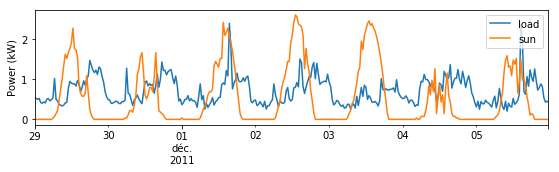

In [148]:
fig = plt.figure(figsize=(8,2.5))
P_load.plot(label='load')
P_sun.plot(label='sun')
plt.legend()
plt.ylabel('Power (kW)')
fig.tight_layout()
fig.savefig('data_week_2011-11-29.pdf', bbox_inches='tight')

## Load results

In [71]:
%matplotlib inline

In [169]:
res = pd.read_csv('methods/julia_jump_mpc/results/anticipative.csv', index_col=0, parse_dates=True)
#res = pd.read_csv('methods/julia_jump_mpc/results/fixed.csv', index_col=0, parse_dates=True)

P_pv = P_sun - res.P_curt
print('E_load: {:6.2f} kWh (data)'.format(P_load.sum()*dt))
print('E_sun:  {:6.2f} kWh (data)'.format(P_sun.sum()*dt))
print('E_pv:   {:6.2f} kWh'.format(P_pv.sum()*dt))
print('E_curt: {:6.2f} kWh'.format(res.P_curt.sum()*dt))
print('E_grid: {:6.2f} kWh'.format(res.P_grid.sum()*dt))

E_load: 118.27 kWh (data)
E_sun:   88.96 kWh (data)
E_pv:    88.96 kWh
E_curt:   0.00 kWh
E_grid:  29.31 kWh


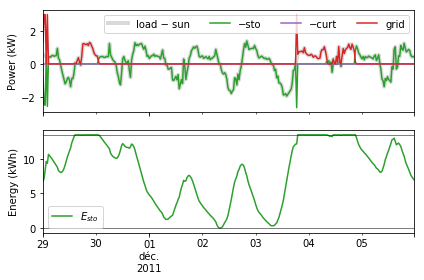

In [170]:
fig, ax = plt.subplots(2,1, sharex=True)

(P_load - P_sun).plot(ax=ax[0], label='load − sun',
                      color=(0.85,)*3, lw=4, )
(-res.P_sto).plot(ax=ax[0], label='−sto',
                  color='tab:green', ls='-')
(-res.P_curt).plot(ax=ax[0], label='−curt',
                   color='tab:purple')
res.P_grid.plot(ax=ax[0], label='grid',
                color='tab:red')


ax[0].legend(ncol=4)
ax[0].set(
    ylabel='Power (kW)'
)

res.E_sto.plot(ax=ax[1], label='$E_{sto}$',
               color='tab:green');
ax[1].axhline(0, color='k', lw=0.5)
ax[1].axhline(E_rated, color='k', lw=0.5)

ax[1].legend()
ax[1].set(
    ylabel='Energy (kWh)',
    ylim=(-.05*E_rated, 1.05*E_rated)
)
fig.tight_layout()
fig.savefig('julia_anticipative.pdf', bbox_inches='tight')